date and time = 07/03/2021 13:54:35
Number of GPU devices:  1


/opt/conda/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:2872: UserWarning: Explicitly requested dtype <class 'complex'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "zeros")
/opt/conda/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:2816: ComplexWarning: Casting complex values to real discards the imaginary part
  out = lax.convert_element_type(out, dtype)


--- the LG coefficients initiated are: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ---

--- the Crystal coefficients initiated are: [1.2533141 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.       ] ---

--- initialization time: 5.607700347900391 seconds ---
--- training mode ---
Epoch 0/20 is running
Epoch 0 in 83.97 sec
optimized LG coefficients: [ 0.9889361  -0.04944792  0.04944795 -0.04944772  0.04944795  0.04944752
 -0.04944794 -0.04944793 -0.04944789  0.04944793]
Norm of LG coefficients: 1.0000004768371582
optimized crystal coefficients: [1.2533141 0.        0.        0.        0.        0.        0.
 0.  

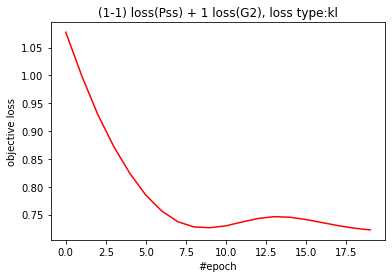

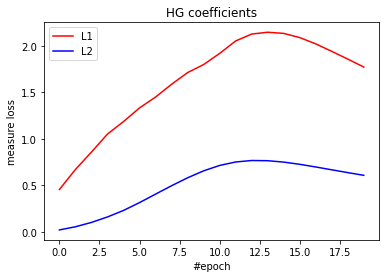

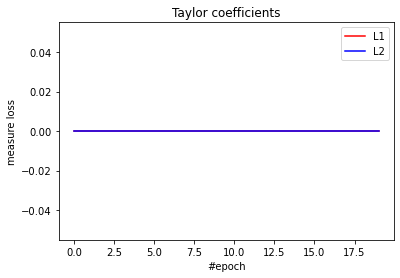

--- inference mode ---
--- saving/plotting results ---
1.0


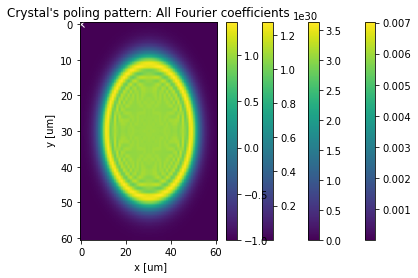

In [1]:
from __future__ import print_function, division, absolute_import
from loss_funcs import l1_loss, kl_loss, sinkhorn_loss, l2_loss
from spdc_helper import *
from spdc_funcs import *
from physical_params import *

JAX_ENABLE_X64 = False
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# datetime object containing current date and time
now       = datetime.now()
print("date and time =", now.strftime("%d/%m/%Y %H:%M:%S"))
start_time_initialization = time.time()

learn_mode = True  # learn/infer
save_stats = False
show_res   = False   # display results 0/1
save_res   = True  # save results
save_tgt   = False  # save targets

learn_crystal = False
res_path       = 'results/'  # path to results folder
Pt_path        = 'targets/'  # path to targets folder
stats_path     = 'stats/'

"Learning Hyperparameters"
loss_type   = 'kl'  # l1:L1 Norm, kl:Kullback Leibler Divergence, wass: Wasserstein (Sinkhorn) Distance"
step_size   = 0.05
num_epochs  = 20
batch_size  = 1000   # 10, 20, 50, 100 - number of iterations
N           = 1000   # 100, 500, 1000  - number of total-iterations (dataset size)

num_batches, Ndevice, batch_device, num_devices = calc_and_asserts(N, batch_size)

"Interaction Initialization"
# Structure arrays - initialize crystal and structure arrays
PP_SLT      = Crystal(dx, dy, dz, MaxX, MaxY, MaxZ, d33)
M           = len(PP_SLT.x)  # simulation size

"""
* define two pump's function (for now n_coeff must be 2) to define the pump *
* this should be later changed to the definition given by Sivan *
"""
max_mode_p = 1
max_mode_l = 4
max_mode1  = 10  # (2*max_mode_l+1)
max_mode2  = 1   # max_mode_p
n_coeff    = max_mode1*max_mode2  # coefficients of LG beam-basis functions

# set the number of modes (radial for LG or y for HG) to allow the crystal to learn
max_mode_crystal = 5

projection_type = 'HG'

Pump     = Beam(lam_pump, PP_SLT, Temperature, waist_pump, power_pump, projection_type, max_mode1, max_mode2)  # wavelength, crystal, tmperature,waist,power, maxmode
#  signal_waist - add here a computation of the signal waist
Signal   = Beam(lam_signal, PP_SLT, Temperature, np.sqrt(2)*Pump.waist, power_signal, projection_type, max_mode1, max_mode2, z=MaxZ/2)
Idler    = Beam(SFG_idler_wavelength(Pump.lam, Signal.lam), PP_SLT, Temperature, np.sqrt(2)*Pump.waist, power_signal, projection_type)

# phase mismatch
delta_k              = Pump.k - Signal.k - Idler.k
PP_SLT.poling_period = dk_offset * delta_k
"Interaction Parameters"
Nx = len(PP_SLT.x)
Ny = len(PP_SLT.y)

# normalization factor
g1_ss_normalization = G1_Normalization(Signal.w)
g1_ii_normalization = G1_Normalization(Idler.w)
coeffs         = HG_coeff_array(coeffs_str, max_mode1*max_mode2)
phi_parameters = poling_array(poling_str, max_mode1*max_mode_crystal)

#Settings for Fourier-Bessel or Hermite-Gauss crystal hologram
if projection_type == 'LG':
    Poling = Poling_profile(phi_scale, r_scale, PP_SLT.x, PP_SLT.y,  PP_SLT.MaxX, max_mode_l, max_mode_crystal, 'fourier_hankel')
elif projection_type == 'HG':
    Poling = Poling_profile(phi_scale, r_scale, PP_SLT.x, PP_SLT.y,  PP_SLT.MaxX, max_mode1, max_mode_crystal, 'hermite')


#Only for normalizing phi_parameters
Poling.create_profile(phi_parameters)
phi_parameters = Poling.phi_parameters_norm

# replicate parameters for gpus
if learn_crystal:
    params = pmap(lambda x: phi_parameters)(np.arange(num_devices))
else:
    params = pmap(lambda x: np.concatenate((coeffs, phi_parameters)))(np.arange(num_devices))

print("--- the LG coefficients initiated are: {} ---\n".format(coeffs))
print("--- the Crystal coefficients initiated are: {} ---\n".format(phi_parameters))
print("--- initialization time: %s seconds ---" % (time.time() - start_time_initialization))
start_time = time.time()

topic = now.strftime("%_Y-%m-%d") + "_Nb{}_Nx{}Ny{}_z{}_steps{}".format(batch_size, Nx, Ny, PP_SLT.MaxZ, len(PP_SLT.z))
if learn_mode:
    topic += "_loss_{}".format(loss_type) + "_N{}".format(N) + "_epochs{}".format(num_epochs)

@jit
def forward(params, vac_):  # vac_ = vac_s, vac_i
    N = vac_.shape[0]
    if learn_crystal:
        #global coeffs
        #To Eyal: No idea why, but I have to run the above line in order for
        # the learn_crystal TRUE mode to work, and comment it out if learn_crystal is FALSE
        # Can you please check this bug?
        phi_parameters = params
    else:
        #global coeffs
        coeffs, phi_parameters = params[:n_coeff], params[n_coeff:]

    # initialize the vacuum and output fields:
    Siganl_field    = Field(Signal, PP_SLT, vac_[:, 0], N)
    Idler_field     = Field(Idler, PP_SLT, vac_[:, 1], N)

    # current pump structure
    Pump.create_profile(coeffs)

    # current poling profile
    Poling.create_profile(phi_parameters)
    phi_normalization = Poling.normalization
    phi_parameters = Poling.phi_parameters_norm

    # Propagate through the crystal:
    crystal_prop(Pump, Siganl_field, Idler_field, PP_SLT, Poling)
    #WAS: reshape(N, max_mode1, max_mode2)
    E_s_out = decompose(Siganl_field.E_out, Signal.hermite_arr).reshape(N, max_mode2, max_mode1)
    E_i_out = decompose(Idler_field.E_out, Signal.hermite_arr).reshape(N, max_mode2, max_mode1)
    E_i_vac = decompose(Idler_field.E_vac, Signal.hermite_arr).reshape(N, max_mode2, max_mode1)
    # say there are no higher modes by normalizing the power
    E_s_out = fix_power1(E_s_out, Siganl_field.E_out, Signal, PP_SLT)
    E_i_out = fix_power1(E_i_out, Idler_field.E_out, Signal, PP_SLT)
    E_i_vac = fix_power1(E_i_vac, Idler_field.E_vac, Signal, PP_SLT)

    #WAS: .reshape(max_mode1*max_mode1, max_mode2*max_mode2)
    G2   = G2_calc(E_s_out, E_i_out, E_i_vac, batch_size).reshape(max_mode2*max_mode2, max_mode1*max_mode1)
    return G2

def loss(params, vac_, G2t):  # vac_ = vac_s, vac_i, G2t = P and G2 target correlation matrices
    if learn_crystal:
        phi_parameters = params
    else:
        coeffs, phi_parameters = params[:n_coeff], params[n_coeff:]
        coeffs = coeffs / np.sqrt(np.sum(np.abs(coeffs)**2))
        params = np.concatenate((coeffs, phi_parameters))

    G2 = forward(params, vac_)
    G2       = G2 / np.sum(np.abs(G2))

    if loss_type is 'l1':
        return l1_loss(G2, G2t)
    if loss_type is 'l2':
        return l2_loss(G2, G2t)
    if loss_type is 'kl':
        return kl_loss(G2, G2t, eps=1e-2)
    if loss_type is 'wass':
        return sinkhorn_loss(G2, G2t, n_coeff, eps=1e-3, max_iters=100, stop_thresh=None)
    else:
        raise Exception('Nonstandard loss choice')

@partial(pmap, axis_name='device')
def update(opt_state, i, x, G2t):
    params              = get_params(opt_state)
    batch_loss, grads   = value_and_grad(loss)(params, x, G2t)
    grads               = np.array([lax.psum(dw, 'device') for dw in grads])
    return lax.pmean(batch_loss, 'device'), opt_update(i, grads, opt_state)

if learn_mode:
    print("--- training mode ---")
    # load target: G2
    G2t        = pmap(lambda x: np.load(Pt_path + targert_folder + 'G2.npy'))(np.arange(num_devices))

    coeffs_gt = np.load(Pt_path + targert_folder + 'HG_coeffs.npy')
    phi_parameters_gt = np.load(Pt_path + targert_folder + 'Taylor_coeffs.npy')

    assert len(coeffs) == len(coeffs_gt), "HG parameters and its ground truth must contain same length"
    assert len(phi_parameters) == len(phi_parameters_gt), "Taylor series phi parameters and its ground truth must contain same length"

    """Set dataset - Build a dataset of pairs Ai_vac, As_vac"""
    # seed vacuum samples
    keys = random.split(random.PRNGKey(1986), num_devices)
    # generate dataset for each gpu
    vac_rnd = pmap(lambda key: random.normal(key, (Ndevice, 2, 2, Nx, Ny)))(keys) # N iteration for device, 2-for vac states for signal and idler, 2 - real and imag, Nx X Ny for beam size)

    # split to batches
    def get_train_batches(vac_, key_):
        vac_shuff = random.permutation(key_, vac_)
        batch_arr = np.split(vac_shuff, num_batches, axis=0)
        return batch_arr

    # seed shuffle batches in epochs
    key_batch_epoch = pmap(lambda i: random.split(random.PRNGKey(1989), num_epochs))(np.arange(num_devices))

    # Use optimizers to set optimizer initialization and update functions
    opt_init, opt_update, get_params = optimizers.adam(step_size, b1=0.9, b2=0.999, eps=1e-08)
    opt_state = opt_init(params)
    obj_loss = []
    l1_HG_loss, l2_HG_loss = [], []
    l1_tylor_loss, l2_tylor_loss = [], []
    for epoch in range(num_epochs):
        obj_loss_epoch = 0.0
        start_time_epoch = time.time()
        batch_set = pmap(get_train_batches)(vac_rnd, key_batch_epoch[:, epoch])
        print("Epoch {}/{} is running".format(epoch,num_epochs))
        for i, x in enumerate(batch_set):
            idx = pmap(lambda x: np.array(epoch+i))(np.arange(num_devices))
            batch_loss, opt_state = update(opt_state, idx, x, G2t)
            obj_loss_epoch += batch_loss[0].item()
        params = get_params(opt_state)
        obj_loss.append(obj_loss_epoch/(i+1))
        epoch_time = time.time() - start_time_epoch
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        ''' print loss value'''
        if learn_crystal:
            phi_parameters = params[0]
        else:
            coeffs, phi_parameters = params[0][:n_coeff], params[0][n_coeff:]
            coeffs = coeffs / np.sqrt(np.sum(np.abs(coeffs)**2))

        l1_HG_loss.append(np.sum(np.abs(coeffs-coeffs_gt)))
        l2_HG_loss.append(np.sum((coeffs-coeffs_gt)**2))
        l1_tylor_loss.append(np.sum(np.abs(phi_parameters - phi_parameters_gt)))
        l2_tylor_loss.append(np.sum((phi_parameters - phi_parameters_gt) ** 2))
        print("optimized LG coefficients: {}".format(coeffs))
        print("Norm of LG coefficients: {}".format(np.sum((np.abs(coeffs))**2)))

        print("optimized crystal coefficients: {}".format(phi_parameters))
        #print("Crystal poling maximal value: {}".format(phi_normalization))

        print("objective loss:{:0.6f}".format(obj_loss[epoch]))
#        print("l1 HG coeffs loss:{:0.6f}".format(l1_HG_loss[epoch]))
#        print("l2 HG coeffs loss:{:0.6f}".format(l2_HG_loss[epoch]))
#        print("l1 Taylor coeffs loss:{:0.6f}".format(l1_tylor_loss[epoch]))
#        print("l2 Taylor coeffs loss:{:0.6f}".format(l2_tylor_loss[epoch]))


    print("--- training time: %s seconds ---" % (time.time() - start_time))

    curr_dir = stats_path + topic
    if os.path.isdir(curr_dir):
        for filename in os.listdir(curr_dir):
            os.remove(curr_dir + '/' + filename)
    else:
        os.makedirs(curr_dir)
    exp_details = open(curr_dir + '/' + "exp_details.txt", "w")
    exp_details.write(make_beam_from_HG_str(Pump.hermite_str, coeffs, coeffs_str, coeffs_gt))
    exp_details.write(make_taylor_from_phi_str(phi_parameters, poling_str, phi_parameters_gt))
    exp_details.close()
    

    plt.plot(obj_loss, 'r')
    plt.title('loss(G2), loss type:{}'.format(loss_type))
    plt.ylabel('objective loss')
    plt.xlabel('#epoch')
    # plt.ylim(0, 1)
    if save_stats:
        plt.savefig(curr_dir + '/objective_loss')
    plt.show()
    plt.close()

    plt.plot(l1_HG_loss, 'r', label='L1')
    plt.plot(l2_HG_loss, 'b', label='L2')
    plt.title('HG coefficients')
    plt.ylabel('measure loss')
    plt.xlabel('#epoch')
    # plt.ylim(0, 5)
    plt.legend()
    if save_stats:
        plt.savefig(curr_dir + '/HG_coeffs_losses')
    plt.show()
    plt.close()

    plt.plot(l1_tylor_loss, 'r', label='L1')
    plt.plot(l2_tylor_loss, 'b', label='L2')
    plt.title('Taylor coefficients')
    plt.ylabel('measure loss')
    plt.xlabel('#epoch')
    plt.legend()
    if save_stats:
        plt.savefig(curr_dir + '/Taylor_coeffs_losses')
    plt.show()
    plt.close()

# show last epoch result
if save_res or save_tgt or show_res:
    print("--- inference mode ---")
    N_res = batch_size
    ###########################################
    # Set dataset
    ##########################################
    # Build a dataset of pairs Ai_vac, As_vac

    # seed vacuum samples
    keys = random.split(random.PRNGKey(1986), num_devices)
    # generate dataset for each gpu
    vac_rnd = pmap(lambda key: random.normal(key, (batch_device, 2, 2, Nx, Ny)))(keys)  # number of devices, N iteration, 2-for vac states for signal and idler, 2 - real and imag, Nx X Ny for beam size)

    G2 = pmap(forward)(params, vac_rnd)
    G2       = G2.sum(0)

    if save_tgt:
        print("--- saving targets ---")
        curr_dir = Pt_path + topic
        if os.path.isdir(curr_dir):
            for filename in os.listdir(curr_dir):
                os.remove(curr_dir + '/' + filename)
        else:
            os.makedirs(curr_dir)

        G2_t_name = 'G2'
        # save normalized version
        np.save(curr_dir + '/' + G2_t_name, G2 / np.sum(np.abs(G2)))

        np.save(curr_dir + '/HG_coeffs', coeffs)
        np.save(curr_dir + '/Taylor_coeffs', phi_parameters)

        exp_details = open(curr_dir + '/' + "exp_details.txt", "w")
        if learn_mode:
            exp_details.write(make_beam_from_HG_str(Pump.hermite_str, coeffs, coeffs_str, coeffs_gt))
            exp_details.write(make_taylor_from_phi_str(phi_parameters, poling_str, phi_parameters_gt))
        else:
            exp_details.write(make_beam_from_HG_str(Pump.hermite_str, coeffs, coeffs_str))
            exp_details.write(make_taylor_from_phi_str(phi_parameters, poling_str))
        exp_details.close()

    if show_res or save_res:
        print("--- saving/plotting results ---")

        curr_dir = res_path + topic
        if os.path.isdir(curr_dir):
            for filename in os.listdir(curr_dir):
                os.remove(curr_dir + '/' + filename)
        else:
            os.makedirs(curr_dir)

        exp_details = open(curr_dir + '/' + "exp_details.txt", "w")
        if learn_mode:
            exp_details.write(make_beam_from_HG_str(Pump.hermite_str, coeffs, coeffs_str, coeffs_gt))
            exp_details.write(make_taylor_from_phi_str(phi_parameters, poling_str, phi_parameters_gt))

        else:
            exp_details.write(make_beam_from_HG_str(Pump.hermite_str, coeffs, coeffs_str))
            exp_details.write(make_taylor_from_phi_str(phi_parameters, poling_str))
        exp_details.close()

        ################
        # Plot G2 #
        ################
        # Unwrap G2 indices
        G2_unwrap_idx_str = 'G2_unwarp_idx/G2_unwrap_max_mode{}.npy'.format(max_mode1*max_mode2)
        savetime_flag = 0
        if savetime_flag:
            if not os.path.exists(G2_unwrap_idx_str):
                G2_unwrapped_idx_np = onp.zeros((max_mode1, max_mode2, max_mode1, max_mode2), dtype='int32')
                print(np.shape(onp.arange(0, max_mode1 * max_mode2 * max_mode1 * max_mode2, dtype='int32').reshape(
                    max_mode1 * max_mode2, max_mode1 * max_mode2)))
                print(np.shape(G2_unwrapped_idx_np))
                G2_unwrapped_idx_np = \
                    unwrap_kron(G2_unwrapped_idx_np,
                                onp.arange(0, max_mode1 * max_mode2 * max_mode1 * max_mode2, dtype='int32').reshape(max_mode1 * max_mode1, max_mode2 * max_mode2),
                                max_mode1, max_mode2).reshape(max_mode1 * max_mode2 * max_mode1 * max_mode2).astype(int)

                np.save(G2_unwrap_idx_str, G2_unwrapped_idx_np)

            else:
                G2_unwrapped_idx_np = np.load(G2_unwrap_idx_str)
            G2_unwrapped_idx = onp.ndarray.tolist(G2_unwrapped_idx_np)
            del G2_unwrapped_idx_np

            G2 = G2.reshape(max_mode1 * max_mode2 * max_mode1 * max_mode2)[G2_unwrapped_idx].reshape(max_mode1, max_mode2, max_mode1, max_mode2)
        else:
            G2_tensor = onp.zeros((max_mode2, max_mode1, max_mode2, max_mode1), dtype='int32')
            G2 = unwrap_kron(G2_tensor, G2, max_mode2, max_mode1)


        # Compute and plot reduced G2
        #G2_reduced = trace_it(G2, 0, 2)
        G2_reduced = G2[0,:,0,:]
        G2_reduced = G2_reduced * tau / (g1_ii_normalization * g1_ss_normalization)

        # plot
        plt.imshow(G2_reduced)
        plt.title(r'$G^{(2)}$ (coincidences)')
        plt.xlabel(r'signal mode i')
        plt.ylabel(r'idle mode j')
        plt.colorbar()
        if save_res:
            plt.savefig(curr_dir + '/' + 'G2')
        if show_res:
            plt.show()

        #Save arrays
        np.save(curr_dir + '/' + 'PolingCoeffs.npy', phi_parameters)
        np.save(curr_dir + '/' + 'PumpCoeffs.npy', coeffs)
        np.save(curr_dir + '/' + 'G2.npy', G2)


        # crystal's pattern
        #XX, ZZ = np.meshgrid(PP_SLT.x, PP_SLT.z)

        #Save poling
        if projection_type == 'LG':
            PolingToSave = Poling_profile(phi_scale, r_scale, PP_SLT.x, PP_SLT.y, PP_SLT.MaxX, max_mode_l, max_mode_crystal,
                                'fourier_hankel')
        elif projection_type == 'HG':
            PolingToSave = Poling_profile(phi_scale, r_scale, PP_SLT.x, PP_SLT.y, PP_SLT.MaxX, max_mode1, max_mode_crystal,
                                'hermite')
        PolingToSave.create_profile(phi_parameters)
        magnitude = np.abs(PolingToSave.crystal_profile)
        print(np.max(magnitude))
        DutyCycle = np.arcsin(magnitude)/np.pi
        phase = np.angle(PolingToSave.crystal_profile)
        #plot and save the first Fourier coefficient of the cyrstal poling
        CrystalFourier = 0
        for m in [1]: #in range(100)
            if m==0:
                CrystalFourier = CrystalFourier + 2*DutyCycle - 1
            else:
                CrystalFourier = CrystalFourier + (2 / (m * np.pi)) * np.sin(m* pi * DutyCycle) * 2 * np.cos(m * phase)

        plt.imshow(CrystalFourier, aspect='auto')
        plt.xlabel(' x [um]')
        plt.ylabel(' y [um]')
        plt.title('Crystal\'s poling pattern: 1st Fourier coefficient')
        plt.colorbar()
        if save_res:
            plt.savefig(curr_dir + '/' + 'poling_1stFourier')
        if show_res:
            plt.show()
        #plot and save also the full cyrstal poling with all Fourier coefficients
        CrystalFourier = 0
        for m in range(100):
            if m==0:
                CrystalFourier = CrystalFourier + 2*DutyCycle - 1
            else:
                CrystalFourier = CrystalFourier + (2 / (m * np.pi)) * np.sin(m* pi * DutyCycle) * 2 * np.cos(m * phase)

        plt.imshow(CrystalFourier, aspect='auto')
        plt.xlabel(' x [um]')
        plt.ylabel(' y [um]')
        plt.title('Crystal\'s poling pattern: All Fourier coefficients')
        plt.colorbar()
        if save_res:
            plt.savefig(curr_dir + '/' + 'poling_AllFourier')
        if show_res:
            plt.show()
        # plot and save pump
       


--- Done: 263.89381551742554 seconds ---


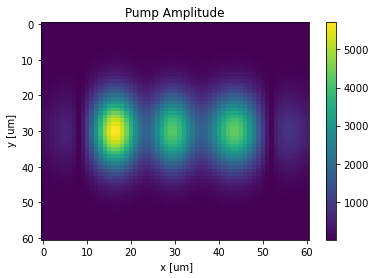

In [2]:
        Pump.create_profile(coeffs)
        plt.imshow(np.squeeze(np.abs(Pump.E)), aspect='auto')
        plt.xlabel(' x [um]')
        plt.ylabel(' y [um]')
        plt.title('Pump Amplitude')
        plt.colorbar()
        if save_res:
            plt.savefig(curr_dir + '/' + 'pumpamplitude')
        
print("\n--- Done: %s seconds ---" % (time.time() - start_time))
exit()